<a href="https://colab.research.google.com/github/felipecostapereira/ELE2389_RedesNeurais/blob/main/class_pratica1_Felipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Para cada item da lista de exercício, não esqueça de fazer uma análise pertinente dos resultados obtidos.

<b> Importante: </b> faça uma média dos resultados para cada item. Como o modelo é estocástico, os resultados podem variar de acordo com a inicialização dos pesos.

# Redes Neurais
## 1ª Lista de Exercícios - Classificação de padrões


Aluno: Felipe da Costa Pereira

Base de dados: breast_cancer

In [538]:
import numpy as np 
import pandas as pd 
import json
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
from time import sleep
import random
from IPython.display import Image

import torch 
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler, Dataset, DataLoader 
import torch.nn.functional as F

from tqdm.notebook import tqdm

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

#allow to print all variables in the notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Descomentar caso queira utilizar no Google Colab
# from google.colab import drive 
# drive.mount('/content/drive')

In [539]:
class CustomDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)



In [540]:
def plot_confusion_matrix(cm,
                          target_names=None,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if target_names is None:
        target_names = [i for i in range(cm.shape[0])]

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [541]:
def piecewise_norm(vec,val,n):
    '''
    Função para normalização por partes. 
    Argumentos de entrada:
    - vec: vetor com valores de um atributo. 
    - val: valor (na escala original) que deve ocorrer a quebra entre retas.
    - n: valor (normalizado) que deve ocorrer a quebra entre retas.
    '''
    
    assert val > min(vec)
    
    return np.where(vec < val, n*(vec - min(vec))/(val - min(vec)), (1-n)*(vec - val)/(max(vec) - val) + n)

In [542]:
def transform_data(dataset,dataset_columns,normalize=True):
    '''
    Função para transformação de dados para a 1ª Lista de exercícios.
    A transformação possui duas etapas: codificação de variáveis categóricas e normalização de atributos numéricos.
    Parâmetros de entrada:
    - dataset: base de dados a ser ajeitado.
    - dataset_columns: dicionário contendo o nome da coluna e "classe", podendo ser 'numeric', 'categorical' ou 'target'
    - normalize: normalização de atributos utilizando min-max. Default: True.

    A função retorna um dataframe com os atributos categóricos codificados e normalizados (caso normalize = True).
    '''

    new_df = pd.DataFrame()

    #Varre todas as colunas do dataframe.
    for name in dataset.columns:

        #Avalia se a coluna está dentro da lista de colunas com descritores.
        if name in dataset_columns.keys():
            
            #Tratamento de dados utilizando o atributo categórico. No caso, é utilizada a codificação 1 of N.
            if dataset_columns[name] == 'categorical':
                raw_data = dataset[name].values
                d_encoder = LabelEncoder()
                d_encoder.fit(raw_data)
                d_encoded = d_encoder.transform(raw_data)
                #dummy_y = to_categorical(d_encoded)
                dim = len(d_encoder.classes_)
                dummy_y = np.eye(dim)[d_encoded]
                
                for (j,k) in enumerate(d_encoder.classes_):
                    new_df[f'{name}_{k}'] = dummy_y[:,j].astype('int')
            
            
            #Caso numérico, utilizando normalização min-max
            elif dataset_columns[name] == 'numeric':
                raw_data = dataset[name].values
                if normalize:
                    new_df[name] = (raw_data - min(raw_data))/(max(raw_data) - min(raw_data))
                else:
                    new_df[name] = raw_data
                
            #Caso 'original', sem mudança nos valores.
            elif dataset_columns[name] == 'original':
                new_df[name] = dataset[name].values
            
            #Caso target, sem mudança nos valores.
            elif dataset_columns[name] == 'target':
                new_df[name] = dataset[name].values
                
    return new_df

In [543]:
class NeuralNetwork(torch.nn.Module):
  '''
  Objeto criado para facilitar o desenvolvimento dos scripts das aulas práticas.
  Opção alternativa à criação externa fdo modelo. Basicamente serve como um 
  'agregador'  de trechos comuns para a criação do modelo. Por exemplo, ao invés
  de gastar n+1 linhas para a criação de um modelo com n camadas, podemos criar 
  o mesmo modelo com apenas uma linha.
  
  Parâmetros de entrada: 
  - hidden_neurons: Lista com a quantidade de neurônios na camada escondida. 
  - hidden_activation: Função de ativação para cada camada escondida. Aceita 
  como parâmetro string ou lista. Caso o parâmetro receba string, então a mesma
  função de ativação é utilizada para todas as camadas escondidas. Caso seja uma 
  lista, cada camada terá sua propria função de ativação definida pela lista.
  - output_activation: Função de ativação para a camada de saída.
  - lr: Taxa de aprendizado
  - n_input: Tamanho do vetor de entrada.
  - n_output: Saída do modelo.
  '''
  def __init__(self,hidden_neurons = 4, hidden_activation = 'relu', output_activation='softmax', lr = 0.05, n_input = 1, n_output = 1):
    # create model
    super(NeuralNetwork, self).__init__()

    self.activations = {'relu': nn.ReLU(), 'sigmoid':nn.Sigmoid(), 'softmax':nn.Softmax()}

    self.fc1 = nn.Linear(n_input, hidden_neurons)
    self.ha = self.activations[hidden_activation]
    self.fc2 = nn.Linear(hidden_neurons, n_output)
    #self.out = self.activations[output_activation]
    
    #self.out = nn.Sigmoid() #Para o caso binário
  def forward(self,x):
    h = self.fc1(x)
    h1 = self.ha(h) 
    y = self.fc2(h1) 
    #y = self.out(h2)
    return y

  def predict(self, x, binary=True):
    y_hat = self.forward(x)

    if binary:
      y_pred = torch.round(torch.sigmoid(y_hat))
      y_pred = y_pred.detach().numpy()
    else:
      y_pred = torch.argmax(y_hat, dim=1)

    return y_pred




  


In [544]:
def accuracy(y_pred, y_test):
    y_pred_tags = torch.argmax(y_pred, dim=1)
    
    correct_pred = (y_pred_tags == y_test).float().sum()
    acc = correct_pred / y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

#Binary accuracy
def binary_acc(y_pred, y_test):
    y_pred_tags = torch.round(torch.sigmoid(y_pred))

    correct_pred = (y_pred_tags == y_test).float().sum()
    acc = correct_pred/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

def train(model, train_loader, val_set, epochs, device, lr, binary=True, skip=1, progressBar = True):

  if binary:
    criterion = nn.BCEWithLogitsLoss()
  else:
    criterion = nn.CrossEntropyLoss()

  optimizer = torch.optim.SGD(model.parameters(), lr=lr)
  history = {'acc_train' : [], 'loss_train': [], 'acc_val': [], 'loss_val': []}

  if progressBar:
    for e in tqdm(range(1, epochs+1)):
      
      y_hat = np.array([])

      train_epoch_loss = 0
      train_epoch_acc = 0
      model.train()
      for X_train_batch, y_train_batch in train_loader:
          X, y = X_train_batch.to(device), y_train_batch.to(device)
          optimizer.zero_grad()
          
          y_pred = model(X)
          
          loss = criterion(y_pred, y)
          #acc = accuracy(y_pred, y)
          #Para classificação binária
          if binary:
            acc = binary_acc(y_pred,y)
          else:
            acc = accuracy(y_pred, y)
          
          loss.backward()
          optimizer.step()
          
          train_epoch_loss += loss.item()
          train_epoch_acc += acc.item()
          y_p = torch.argmax(y_pred, dim=1)
          y_hat = np.concatenate((y_hat, y_p))
      
      
      model.eval()
      _, val_loss, val_acc = evaluate(model, val_set, criterion, binary=binary)

      history['acc_train'].append(train_epoch_acc/len(train_loader))
      history['loss_train'].append(train_epoch_loss/len(train_loader))
      history['acc_val'].append(val_acc)
      history['loss_val'].append(val_loss)
      
      if e%skip == 0:
        print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.3f} | Val Loss: {val_loss:.4f} | Train Acc: {train_epoch_acc/len(train_loader):.4f}| Val Acc: {val_acc:.4f}')
  else:
    for e in range(1, epochs+1):
      
      y_hat = np.array([])

      train_epoch_loss = 0
      train_epoch_acc = 0
      model.train()
      for X_train_batch, y_train_batch in train_loader:
          X, y = X_train_batch.to(device), y_train_batch.to(device)
          optimizer.zero_grad()
          
          y_pred = model(X)
          
          loss = criterion(y_pred, y)
          #acc = accuracy(y_pred, y)
          #Para classificação binária
          if binary:
            acc = binary_acc(y_pred,y)
          else:
            acc = accuracy(y_pred, y)
          
          loss.backward()
          optimizer.step()
          
          train_epoch_loss += loss.item()
          train_epoch_acc += acc.item()
          y_p = torch.argmax(y_pred, dim=1)
          y_hat = np.concatenate((y_hat, y_p))
      
      
      model.eval()
      _, val_loss, val_acc = evaluate(model, val_set, criterion, binary=binary)

      history['acc_train'].append(train_epoch_acc/len(train_loader))
      history['loss_train'].append(train_epoch_loss/len(train_loader))
      history['acc_val'].append(val_acc)
      history['loss_val'].append(val_loss)
      
      if e%skip == 0:
        print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.3f} | Val Loss: {val_loss:.4f} | Train Acc: {train_epoch_acc/len(train_loader):.4f}| Val Acc: {val_acc:.4f}')
  return history, y_hat
  

def evaluate(model, val_set, criterion, binary=True):
    X = val_set.X_data
    y = val_set.y_data

    with torch.no_grad():
      y_pred = model(X)
                
    loss = criterion(y_pred, y)
    
    #Para classificação binária
    if binary:
      acc = binary_acc(y_pred, y)
    else:
      acc = accuracy(y_pred, y)

    val_epoch_loss = loss.item()
    val_epoch_acc = acc
    
    return y_pred, val_epoch_loss, val_epoch_acc


In [545]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Preparação dos dados

Não esqueça de verificar o path para a pasta. Mude também o filename, de acordo com a base de dados.

In [546]:
# os.chdir('/content/drive/MyDrive/Colab Notebooks/Mestrado/ELE2389')
# !git clone https://github.com/mdrs-thiago/PUC_Redes_Neurais
os.chdir('/content/drive/MyDrive/Colab Notebooks/Mestrado/ELE2389/PUC_Redes_Neurais/pos_grad/lista_1')
!pwd;ls

/content/drive/MyDrive/Colab Notebooks/Mestrado/ELE2389/PUC_Redes_Neurais/pos_grad/lista_1
 apresentacao_datasets.pptx    loss_tr_val_24feat.png
 class_pratica1_Felipe.ipynb   loss_tr_val_7feat.png
 class_pratica1.ipynb	      'PG - Prática I - Guia de atividades.pdf'
 datasets


In [547]:
#Mudar o rootname para o diretório atual do Notebook.
#root_name = '/content/drive/MyDrive/Monitoria_RN/pratica1 - classificacao/'
root_name = os.getcwd()
dataset = 'breast_cancer'
filename = os.path.join('datasets',dataset)

In [548]:
description_path = os.path.join(root_name,filename,'data_info.json')
with open(description_path,'r') as f:
    dataset_columns = json.load(f)

In [549]:
dataset_path = os.path.join(root_name, filename,f'class_{dataset}.csv')
dataset = pd.read_csv(dataset_path)

In [550]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   569 non-null    int64  
 1   radius               569 non-null    float64
 2   texture              569 non-null    float64
 3   perimeter            569 non-null    float64
 4   area                 569 non-null    float64
 5   smoothness           569 non-null    float64
 6   compacity            569 non-null    float64
 7   concavity            569 non-null    float64
 8   pts_concavity        569 non-null    float64
 9   symmetry             569 non-null    float64
 10  fractal              569 non-null    float64
 11  std_radius           569 non-null    float64
 12  std_texture          569 non-null    float64
 13  std_perimeter        569 non-null    float64
 14  std_area             569 non-null    float64
 15  std_smoothness       569 non-null    flo

In [551]:
dataset.describe()

,ID,radius,texture,perimeter,area,smoothness,compacity,concavity,pts_concavity,symmetry,...,minor_radius,minor_texture,minor_perimeter,minor_area,minor_smoothness,minor_compacity,minor_concavity,minor_pts_concavity,minor_symmetry,minor_fractal
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


## Parte I - Compreensão do problema e análise de variáveis



### 1)	Observe a base de dados do problema. Existem variáveis que podem ser eliminadas do dataset? Justifique.

#### Rascunho

In [552]:
dataset.shape

(569, 32)

In [553]:
dataset['target'].value_counts(normalize=True)

B    0.627417
M    0.372583
Name: target, dtype: float64

Removendo ID e transformando dataset em formato X,y porque alguns métodos de feature selection requerem fit de X e y

In [554]:
dfX = dataset.drop(['target','ID'], axis=1)
target = dataset['target'] 
dfX.shape, target.shape

((569, 30), (569,))

Plotando correlações entre as features

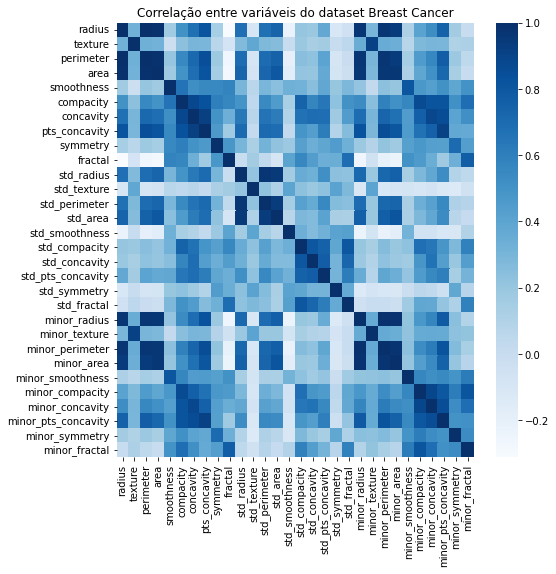

In [555]:
plt.figure(figsize=(8,8))
sns.heatmap(dfX.corr(), cmap='Blues')
plt.title('Correlação entre variáveis do dataset Breast Cancer')
pass;

Nota: Algumas variáveis podem ser excluídas do dataset pois são fortemente correlacionadas com outras, por exemplo:
- radius, texture, perimeter, area, std_radius, std_texture, std_perimeter, std_area, minor_radius, minor_texture, minor_perimeter, minor_area
- concavity, compacity, pts_concavity, etc...

Vamos fazer uma feature selection com Scikit Learn para evitar complexidade desnecessária da rede

In [556]:
dfX.head()

,radius,texture,perimeter,area,smoothness,compacity,concavity,pts_concavity,symmetry,fractal,...,minor_radius,minor_texture,minor_perimeter,minor_area,minor_smoothness,minor_compacity,minor_concavity,minor_pts_concavity,minor_symmetry,minor_fractal
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Seleção de atrubutos mais relevantes

In [557]:
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel, SelectKBest, RFE, mutual_info_classif, chi2

# padronização dos dados de X
dfX_scaled = pd.DataFrame(MinMaxScaler(feature_range=[0,1]).fit_transform(dfX.to_numpy()), columns = dfX.columns)

#@title Selecione o numero de features a serem mantidas no dataset:
#How many features to keep?
n_to_keep = 7 #@param {type:"integer"}

selectors = []
voting = []

# SelectFromModel using 3 classifiers
m1 = LogisticRegression(multi_class='multinomial').fit(dfX_scaled, target)
m2 = LinearSVC().fit(dfX_scaled, target)
m3 = LinearSVC(C=10).fit(dfX_scaled, target)
for model in [m1,m2,m3]:
  selector = SelectFromModel(model, prefit=True)
  selectors.append(selector)

# SelectKBest using 2 different statistics
selector = SelectKBest(mutual_info_classif, k=20).fit(dfX_scaled.to_numpy(), target)
selectors.append(selector)
selector = SelectKBest(chi2, k=15).fit(dfX_scaled.to_numpy(), target)
selectors.append(selector)

# Recursive feature elimination (RFE) using 3 classifiers
m1 = LogisticRegression(multi_class='multinomial').fit(dfX_scaled, target)
m2 = LinearSVC().fit(dfX_scaled, target)
m3 = LinearSVC(C=10).fit(dfX_scaled, target)
for model in [m1,m2,m3]:
  selector = RFE(model, n_features_to_select=20, step=1).fit(dfX_scaled, target)  
  selectors.append(selector)

# percorrendo todos os indices de features selecionadas
for selector in selectors:
  for i in selector.get_support(indices=True):
    voting.append(i)

# n most voted
selected_features = pd.value_counts(voting).head(n_to_keep).index.to_numpy()
selected_features = np.sort(selected_features)
selected_features

array([ 6,  7, 10, 12, 20, 22, 23])

In [558]:
# filtrando dataset com as features selecionadas
dfX_sel = dfX.iloc[:,selected_features]

# devolvendo target (pra garantir o uso correto da funçao transform_data fornecida)
dataset_selected = dfX_sel.join(dataset['target'])

dataset_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   concavity        569 non-null    float64
 1   pts_concavity    569 non-null    float64
 2   std_radius       569 non-null    float64
 3   std_perimeter    569 non-null    float64
 4   minor_radius     569 non-null    float64
 5   minor_perimeter  569 non-null    float64
 6   minor_area       569 non-null    float64
 7   target           569 non-null    object 
dtypes: float64(7), object(1)
memory usage: 35.7+ KB


A partir das features selecionadas, atualizando dicionario de colunas para usar na função transform_data

In [559]:
dataset_columns_selected = dict()
for col in dataset_selected.columns:
  dataset_columns_selected[col] = dataset_columns.get(col)
  
dataset_columns_selected

{'concavity': 'numeric',
 'minor_area': 'numeric',
 'minor_perimeter': 'numeric',
 'minor_radius': 'numeric',
 'pts_concavity': 'numeric',
 'std_perimeter': 'numeric',
 'std_radius': 'numeric',
 'target': 'target'}

#### Resposta

Sim, havia um número muito grande de features que pode levar a rede a uma complexidade desnecessária e uma má generalização. Optou-se por reduzir o numero de features a partir da aplicação de métodos de seleção de atributos do pacote sklearn.feature_selection

In [560]:
print (f'Novo Dataset: {n_to_keep} features\n')
dataset_selected.head()

Novo Dataset: 7 features



,concavity,pts_concavity,std_radius,std_perimeter,minor_radius,minor_perimeter,minor_area,target
0,0.3001,0.14710,1.0950,8.589,25.38,184.60,2019.0,M
1,0.0869,0.07017,0.5435,3.398,24.99,158.80,1956.0,M
2,0.1974,0.12790,0.7456,4.585,23.57,152.50,1709.0,M
3,0.2414,0.10520,0.4956,3.445,14.91,98.87,567.7,M
4,0.1980,0.10430,0.7572,5.438,22.54,152.20,1575.0,M


### 2)	Implemente técnicas de visualização de dados e seleção de variáveis para extrair características importantes sobre a base de dados. Explique a motivação destas técnicas e o que é possível inferir dos resultados obtidos.

#### Rascunho

In [561]:
# Construção de dataset normalizado para plotar parallel_coordinates na mesma escala [0,1]
df_sel_scaled = pd.DataFrame(MinMaxScaler(feature_range=[0,1]).fit_transform(dataset_selected.drop('target', axis=1)), columns = dataset_selected.columns[:-1])
df_sel_scaled['target'] = target
df_sel_scaled.head(3)

,concavity,pts_concavity,std_radius,std_perimeter,minor_radius,minor_perimeter,minor_area,target
0,0.703140,0.731113,0.356147,0.369034,0.620776,0.668310,0.450698,M
1,0.203608,0.348757,0.156437,0.124440,0.606901,0.539818,0.435214,M
2,0.462512,0.635686,0.229622,0.180370,0.556386,0.508442,0.374508,M


In [562]:
# Unpivot no dataset com o método pandas.DataFrame.melt, para plotar estátisticas associadas a todos os atributos
dfResultsPlot = df_sel_scaled.melt(id_vars='target', var_name='feature')
dfResultsPlot.head(3)

,target,feature,value
0,M,concavity,0.703140
1,M,concavity,0.203608
2,M,concavity,0.462512


#### Resposta

Plotting multidimensional com algumas amostras do dataset

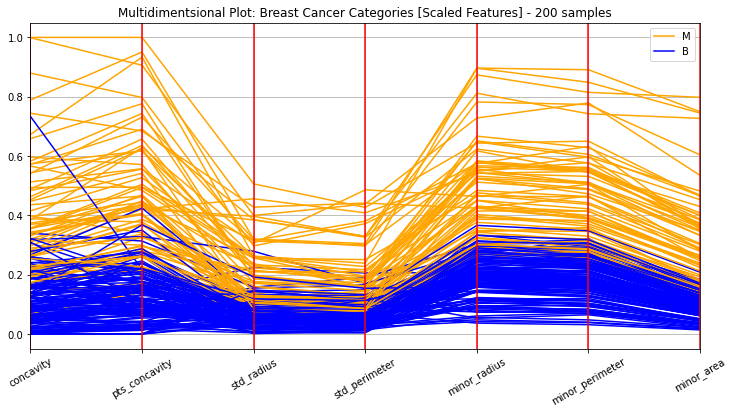

In [563]:
n_samples = 200
plt.figure(figsize=(12,6))
pd.plotting.parallel_coordinates(df_sel_scaled.sample(n_samples), 'target', color=('orange','blue'), axvlines_kwds={"color":"red"})
plt.title(f'Multidimentsional Plot: Breast Cancer Categories [Scaled Features] - {n_samples} samples')
plt.xticks(rotation=30)

pass;

Plotting da distribuição dos valores das features para cada classe do dataset

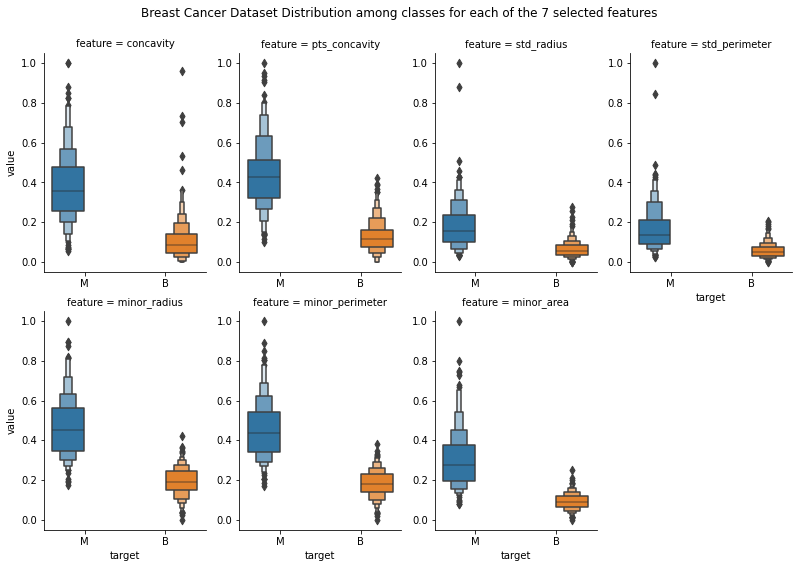

In [564]:
ax = sns.catplot(data=dfResultsPlot, col='feature', y='value', x='target', col_wrap=int(n_to_keep/2+n_to_keep%2), kind='boxen', hue='target', height=4, aspect=0.7, margin_titles=True, sharex=False, sharey=False);
ax.fig.subplots_adjust(top=.9)
ax.fig.suptitle(f'Breast Cancer Dataset Distribution among classes for each of the {n_to_keep} selected features')
pass;

Crossplots de algumas variáveis. Na diagonal principal, sua distribuição, por classe

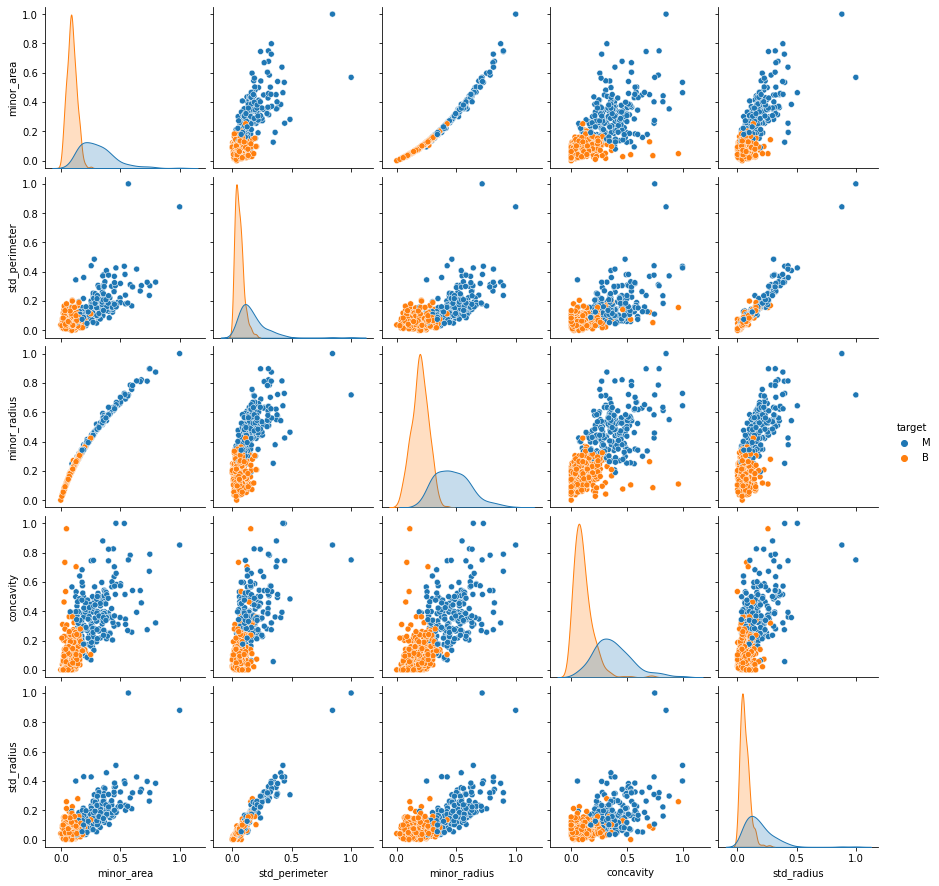

In [565]:
if n_to_keep <= 5:  #plot all
  sns.pairplot(df_sel_scaled, hue='target', diag_kind='kde');
else: # plot only 5
  vars = random.sample(range(0,n_to_keep), 5)
  vars.append(-1) #target
  sns.pairplot(df_sel_scaled.iloc[:,vars], hue='target', diag_kind='kde')
pass;

Nota: a partir dos plots acima entende-se que as classes serão separadas sem muita dificuldade.

## 2.	Treinamento do modelo de Rede Neural

### 1)	Com as configurações do modelo MLP previamente definidas no script, faça o treinamento da Rede Neural sem normalizar os atributos numéricos. Comente o resultado obtido, baseado nas métricas de avaliação disponíveis (acurácia, precision, recall, F1-Score, Matriz de confusão, etc.)

#### Rascunho

Novo datafranme apenas com as features selecionadas

In [566]:
new_df = transform_data(dataset_selected,dataset_columns_selected,normalize=False)
new_df.head()

,concavity,pts_concavity,std_radius,std_perimeter,minor_radius,minor_perimeter,minor_area,target
0,0.3001,0.14710,1.0950,8.589,25.38,184.60,2019.0,M
1,0.0869,0.07017,0.5435,3.398,24.99,158.80,1956.0,M
2,0.1974,0.12790,0.7456,4.585,23.57,152.50,1709.0,M
3,0.2414,0.10520,0.4956,3.445,14.91,98.87,567.7,M
4,0.1980,0.10430,0.7572,5.438,22.54,152.20,1575.0,M


In [567]:
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1
  binary = True
else:
  print('Multiclass classification')
  n_output = len(encoder.classes_)
  binary = False
  #y = np.eye(n_output)[y]

Binary classification


In [568]:
X.shape
!echo
y.shape

(569, 7)

(569,)

In [569]:
batch_size = 32 

In [570]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

y_test.shape

(114,)

In [571]:
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [572]:
model = NeuralNetwork(n_input = n_input, n_output=n_output, output_activation='sigmoid')

In [573]:
lr = 0.01
epochs = 250

history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary, skip=1000);

  0%|          | 0/250 [00:00<?, ?it/s]

In [574]:
y_pred = model.predict(test_dataset.X_data, binary=binary)

#### Resposta

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.62      1.00      0.77        71
           1       0.00      0.00      0.00        43

    accuracy                           0.62       114
   macro avg       0.31      0.50      0.38       114
weighted avg       0.39      0.62      0.48       114



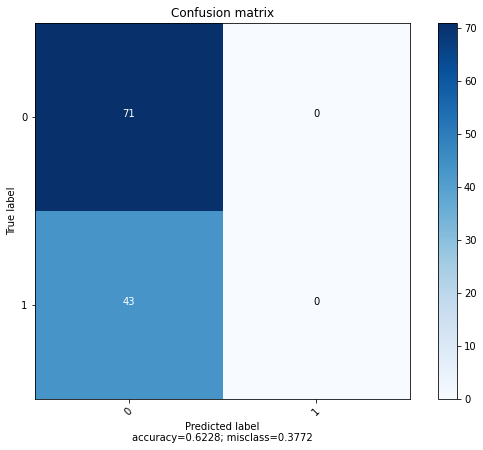

In [575]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

A rede previu todos os labels como 0 (não houve aprendizado). Consequentemente todas as métricas ficaram ruins

### 2)	Agora normalize os dados de entrada e treine novamente o modelo MLP. Avalie os resultados obtidos e comente o efeito da normalização no treinamento da Rede Neural.

#### Rascunho

In [576]:
# new_df = transform_data(dataset,dataset_columns,normalize=True)
new_df = transform_data(dataset_selected,dataset_columns_selected,normalize=True)
new_df.head()

,concavity,pts_concavity,std_radius,std_perimeter,minor_radius,minor_perimeter,minor_area,target
0,0.703140,0.731113,0.356147,0.369034,0.620776,0.668310,0.450698,M
1,0.203608,0.348757,0.156437,0.124440,0.606901,0.539818,0.435214,M
2,0.462512,0.635686,0.229622,0.180370,0.556386,0.508442,0.374508,M
3,0.565604,0.522863,0.139091,0.126655,0.248310,0.241347,0.094008,M
4,0.463918,0.518390,0.233822,0.220563,0.519744,0.506948,0.341575,M


In [577]:
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1

else:
  print('Multiclass classification')
  #y = to_categorical(y)
  n_output = encoder.classes_.shape[0]


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

Binary classification


In [578]:
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [579]:
model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')
history2, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary, skip=50)    

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 050: | Train Loss: 0.625 | Val Loss: 0.6317 | Train Acc: 64.9167| Val Acc: 62.0000
Epoch 100: | Train Loss: 0.543 | Val Loss: 0.5471 | Train Acc: 81.1667| Val Acc: 86.0000
Epoch 150: | Train Loss: 0.433 | Val Loss: 0.4311 | Train Acc: 90.7500| Val Acc: 90.0000
Epoch 200: | Train Loss: 0.344 | Val Loss: 0.3417 | Train Acc: 91.5000| Val Acc: 95.0000
Epoch 250: | Train Loss: 0.287 | Val Loss: 0.2874 | Train Acc: 92.5833| Val Acc: 95.0000


#### Resposta

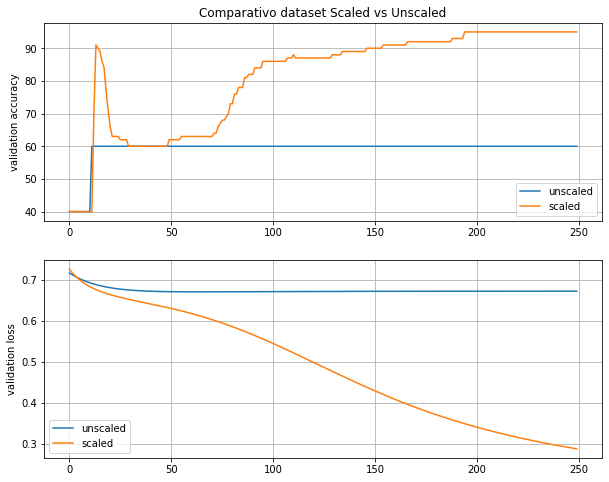

In [580]:
plt.subplots(2,1, figsize=(10,8))

plt.subplot(211)
plt.title('Comparativo dataset Scaled vs Unscaled')
plt.plot(history['acc_val'], label='unscaled')
plt.plot(history2['acc_val'], label='scaled')
plt.ylabel('validation accuracy')
plt.grid()
plt.legend()

plt.subplot(212)
plt.plot(history['loss_val'], label='unscaled')
plt.plot(history2['loss_val'], label='scaled')
plt.ylabel('validation loss')
plt.grid()
plt.legend()

plt.show()
# history.keys()//
pass;

Nota: 

  Houve aprendizado de fato quando as features são normalizadas. O loss continua em queda ao fim de 250 épocas

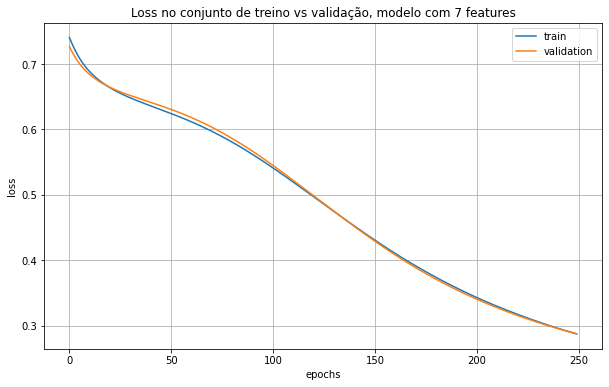

In [581]:
plt.figure(figsize=(10,6))
plt.title(f'Loss no conjunto de treino vs validação, modelo com {n_to_keep} features')
plt.plot(history2['loss_train'], label='train')
plt.plot(history2['loss_val'], label='validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.grid()
pass;

Nota: 

Em 250 épocas não houve aumento do erro de validação, este sempre diminui no treinamento, o que indica que o early stop não trará benefícios, a não ser que modifiquemos a taxa de aprendizado e o numero de épocas.


Outro ponto importante sobre o treinamento: quando o modelo tem poucas features, o loss de treino e validação seguem muito próximos, já quando o modelo tem muitas features, o loss fica ligeiramente maior no conjunto de validação. Isto pode ser um indício de overfit, já que quando o modelo é mais complexo(mais parâmetros, o erro aumenta no conjunto de validação)

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        71
           1       1.00      0.88      0.94        43

    accuracy                           0.96       114
   macro avg       0.97      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114



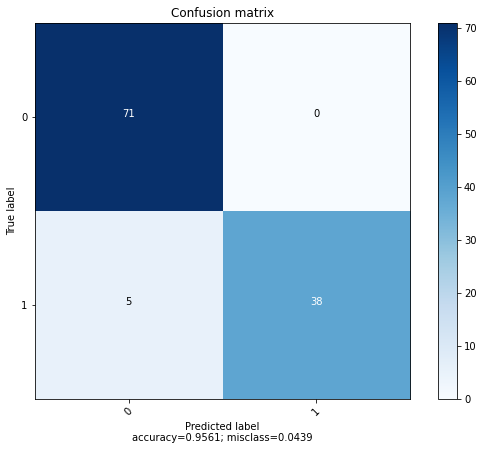

In [582]:
y_pred = model.predict(test_dataset.X_data,binary=binary)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

Agora a matriz de confusão e os valores das métricas de desempenho apresentam a rede neural como um bom modelo classificador dos dados do dataset

## Parte III - Mudança de configurações do modelo

### 1)	Implemente a técnica de parada antecipada (Early Stopping) usando o conjunto de validação. Avalie o resultado obtido.

OBS: crie uma nova função (e.g. train_EarlyStopping) ou use um parâmetro para habilitar/desabilitar o Early Stopping.

#### Rascunho

Rescrevendo train com Early Stop

In [583]:
def train_ES(model, train_loader, val_set, epochs, device, lr, binary=True, skip=1, max_patience = 10):

  if binary:
    criterion = nn.BCEWithLogitsLoss()
  else:
    criterion = nn.CrossEntropyLoss()


  optimizer = torch.optim.SGD(model.parameters(), lr=lr)

  history = {'acc_train' : [], 'loss_train': [], 'acc_val': [], 'loss_val': []}

  for e in tqdm(range(1, epochs+1)):
    
    y_hat = np.array([])

    train_epoch_loss = 0
    train_epoch_acc = 0

    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X, y = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X)
        
        loss = criterion(y_pred, y)
        #acc = accuracy(y_pred, y)
        #Para classificação binária
        if binary:
          acc = binary_acc(y_pred,y)
        else:
          acc = accuracy(y_pred, y)
        
        loss.backward()
        optimizer.step()
        
        train_epoch_loss += loss.item()
        train_epoch_acc += acc.item()
        y_p = torch.argmax(y_pred, dim=1)
        y_hat = np.concatenate((y_hat, y_p))
    
    
    model.eval()
    _, val_loss, val_acc = evaluate(model, val_set, criterion, binary=binary)

    # Early Stop
    # min val é o menor valor de loss do hist, a rede continua aprendendo
    if e == 1: min_val = 1
    if val_loss < min_val:
      min_val = val_loss
      patience = 0
    else:
      patience += 1
      if patience == max_patience:
        print ('***************************************************')
        print ('*******************ES achieved !*******************')
        print ('***************************************************')
        return history, y_hat

    history['acc_train'].append(train_epoch_acc/len(train_loader))
    history['loss_train'].append(train_epoch_loss/len(train_loader))
    history['acc_val'].append(val_acc)
    history['loss_val'].append(val_loss)
    
    if e%skip == 0:
      print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.3f} | Val Loss: {val_loss:.4f} | Train Acc: {train_epoch_acc/len(train_loader):.4f}| Val Acc: {val_acc:.4f}| Patience: {patience:d}')
  return history, y_hat

Importante: Como no modelo anterior o loss sempre diminui, houve dificuldade de implementar o early stop. Pra isso, variamos aqui:

- o numero de parâmetros do modelo para mais features (voltar na parte inicial de feature selaction)
- o numero de épocas;
- a taxa de aprendizado;
- o parâmetro max_patience que é o numero de épocas onde permitimos o aumento do valor de loss antes de parar o treinamento

In [584]:
epochs2 = 500
lr_faster = 0.2
max_patience = 20
skip = 10

model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')
history, y_hat = train(model, train_loader, val_dataset, epochs=epochs2, lr=lr_faster, device=device, binary=binary, skip=skip)

modelES = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')
historyES, y_hatES = train_ES(modelES, train_loader, val_dataset, epochs=epochs2, lr=lr_faster, device=device, binary=binary, max_patience=max_patience, skip=skip)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 010: | Train Loss: 0.568 | Val Loss: 0.5528 | Train Acc: 74.5833| Val Acc: 84.0000
Epoch 020: | Train Loss: 0.263 | Val Loss: 0.2563 | Train Acc: 92.8333| Val Acc: 95.0000
Epoch 030: | Train Loss: 0.200 | Val Loss: 0.2097 | Train Acc: 92.8333| Val Acc: 95.0000
Epoch 040: | Train Loss: 0.180 | Val Loss: 0.1963 | Train Acc: 93.0833| Val Acc: 96.0000
Epoch 050: | Train Loss: 0.171 | Val Loss: 0.1903 | Train Acc: 93.0833| Val Acc: 97.0000
Epoch 060: | Train Loss: 0.166 | Val Loss: 0.1871 | Train Acc: 92.8333| Val Acc: 97.0000
Epoch 070: | Train Loss: 0.163 | Val Loss: 0.1852 | Train Acc: 92.8333| Val Acc: 97.0000
Epoch 080: | Train Loss: 0.161 | Val Loss: 0.1840 | Train Acc: 92.8333| Val Acc: 97.0000
Epoch 090: | Train Loss: 0.159 | Val Loss: 0.1833 | Train Acc: 93.0833| Val Acc: 97.0000
Epoch 100: | Train Loss: 0.158 | Val Loss: 0.1830 | Train Acc: 92.8333| Val Acc: 97.0000
Epoch 110: | Train Loss: 0.158 | Val Loss: 0.1828 | Train Acc: 93.0833| Val Acc: 97.0000
Epoch 120: | Train Lo

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 010: | Train Loss: 0.353 | Val Loss: 0.3402 | Train Acc: 91.5000| Val Acc: 93.0000| Patience: 0
Epoch 020: | Train Loss: 0.222 | Val Loss: 0.2328 | Train Acc: 92.7500| Val Acc: 93.0000| Patience: 0
Epoch 030: | Train Loss: 0.189 | Val Loss: 0.2094 | Train Acc: 92.8333| Val Acc: 96.0000| Patience: 0
Epoch 040: | Train Loss: 0.176 | Val Loss: 0.2001 | Train Acc: 93.0833| Val Acc: 97.0000| Patience: 0
Epoch 050: | Train Loss: 0.169 | Val Loss: 0.1950 | Train Acc: 93.0833| Val Acc: 97.0000| Patience: 0
Epoch 060: | Train Loss: 0.165 | Val Loss: 0.1918 | Train Acc: 92.8333| Val Acc: 97.0000| Patience: 0
Epoch 070: | Train Loss: 0.162 | Val Loss: 0.1897 | Train Acc: 92.8333| Val Acc: 97.0000| Patience: 0
Epoch 080: | Train Loss: 0.160 | Val Loss: 0.1884 | Train Acc: 93.0833| Val Acc: 97.0000| Patience: 0
Epoch 090: | Train Loss: 0.159 | Val Loss: 0.1876 | Train Acc: 92.8333| Val Acc: 97.0000| Patience: 0
Epoch 100: | Train Loss: 0.158 | Val Loss: 0.1871 | Train Acc: 93.0833| Val Acc: 9

#### Resposta

Apesar de termos conseguido realizar o early stop a partir da manipulação dos parâmetros (número de features, epochs, lr e max_patience), somente em algumas realizações da rede obtivemos uma malhora de performance da mesma com a parada antecipada, qunado comparada ao treinamneto convencional. Em geral não houve melhora ou a melhora foi discreta.

Acredito que isso se deva às características do dataset, que não impõe um aumento severo do loss com o passar das épocas, o que evidencia também que não há muito erro de generalização e overfitting, mesmo quando aumentamos significativamente o numero de features e consequentemente, a complexidade do modelo.

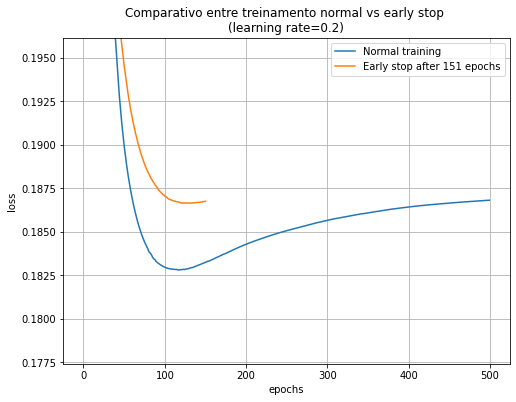

In [585]:
es_epoch = len(historyES['loss_val'])

plt.figure(figsize=(8,6))
plt.title(f'Comparativo entre treinamento normal vs early stop \n(learning rate={lr_faster})')
plt.plot(history['loss_val'], label='Normal training')
plt.plot(historyES['loss_val'], label=f'Early stop after {es_epoch} epochs')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.grid()

#zoom na escala do loss (y) para 'observar melhor' o aumento do loss
last_loss = history['loss_val'][-1]
last_lossES = historyES['loss_val'][-1]
plt.ylim((0.95*min([last_loss, last_lossES]),1.05*max([last_loss, last_lossES])))

pass;

In [586]:
y_pred = model.predict(test_dataset.X_data,binary=binary)
y_pred_ES = modelES.predict(test_dataset.X_data,binary=binary)

!echo 'Normal'
print(classification_report(y_test, y_pred))

!echo;echo 'Early Stop'
print(classification_report(y_test, y_pred_ES))

cm = confusion_matrix(y_test, y_pred)
cmES = confusion_matrix(y_test, y_pred_ES)

# !echo 'Normal'
# plot_confusion_matrix(cm)
# !echo;echo 'Early Stop'
# plot_confusion_matrix(cmES)

Normal
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        71
           1       0.98      0.98      0.98        43

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114


Early Stop
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        71
           1       0.98      0.98      0.98        43

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



### 2)	Modifique o tempo de treinamento (épocas) da Rede Neural. Escolha valores distintos (e.g. 1 e 1000 épocas) e avalie os resultados.
OBS: Não use Early Stopping neste item.

#### Rascunho

Redefinimos anteriormente train para ter a possibilidade de iterar nas épocas sem mostrar a barra de progresso (tqdm)



```
def train(model, ..., progressBar = True):
```



In [587]:
progressBar = False

#### Resposta

A variável n_train_times é utilizada para repetição do treinamento e redução dos efeitos estocásticos (variação da inicialização dos pesos em cada realização)
```
n_train_times = 4 # numero de treinamentos para cada valor de epochs, reduzir efeito estocastico
```
Igualmente, as acurácias médias são calculadas entre os 'n_train_times' treinamentos, de modo que cada valor de 'epochs' tenha uma acuracia média para avaliação posterior.
```
avg_accuracies = [] # registrar a acuracia media para cada valor de epochs entre as repeticoes de treinamento
```
A função loss é plotada para a melhor das realizações do modelo (aquela de maior acurácia)
```
  index_best_model = np.argmax(accuracies)
  plt.plot(losses[index_best_model], label=f'epocsh = {epochs}', linewidth=3)
```







Estudo do loss em função da variação do tempo de treinamento.

epochs = 1


  0%|          | 0/5 [00:00<?, ?it/s]

epochs = 2


  0%|          | 0/5 [00:00<?, ?it/s]

epochs = 20


  0%|          | 0/5 [00:00<?, ?it/s]

epochs = 100


  0%|          | 0/5 [00:00<?, ?it/s]

epochs = 150


  0%|          | 0/5 [00:00<?, ?it/s]

epochs = 250


  0%|          | 0/5 [00:00<?, ?it/s]

epochs = 600


  0%|          | 0/5 [00:00<?, ?it/s]

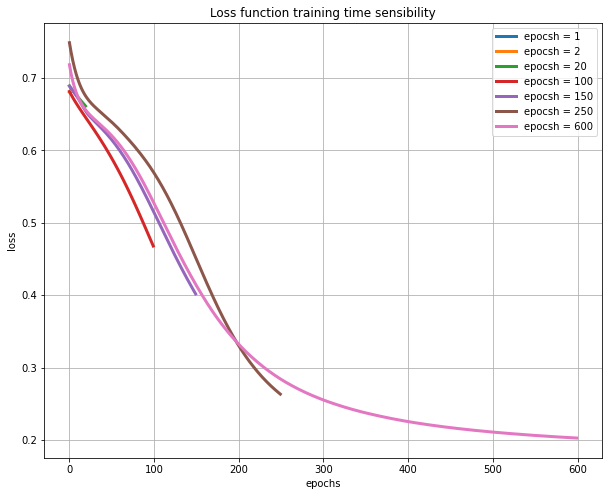

In [588]:
epochs_values = [1,2,20,100,150,250,600]
n_train_times = 5 # numero de treinamentos para cada valor de epochs, reduzir efeito estocastico
avg_accuracies = [] # registrar a acuracia media para cada valor de epochs entre as repeticoes de treinamento
lr=0.01

plt.figure(figsize=(10,8))

for epochs in epochs_values:
  print (f'epochs = {epochs}')
  accuracies = []
  losses = []
  for _ in tqdm(range(n_train_times)):
    model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')
    history, _ = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary, skip=10000, progressBar=progressBar)
    y_pred = model.predict(test_dataset.X_data,binary=binary)
    cm = confusion_matrix(y_test, y_pred)
    accuracies.append( (cm[0,0]+cm[1,1])/cm.sum() )
    losses.append(history['loss_val'])
  accuracies = np.array(accuracies)
  avg_accuracies.append(accuracies.mean())

  # plotting best model (highest accuracy among trainings) loss
  index_best_model = np.argmax(accuracies)
  plt.plot(losses[index_best_model], label=f'epocsh = {epochs}', linewidth=3)

plt.grid()
plt.title('Loss function training time sensibility')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
pass;

Nota-se no gráfico anterior que a rede treinada por mais tempo reflete um maior aprendizado (redução de loss), para uma taxa de aprendizado (lr) fixa, o que implica numa melhor performance de classificação evidenciada pelo grafico a seguir (aumento de acurácia em função do tempo de treinamento)

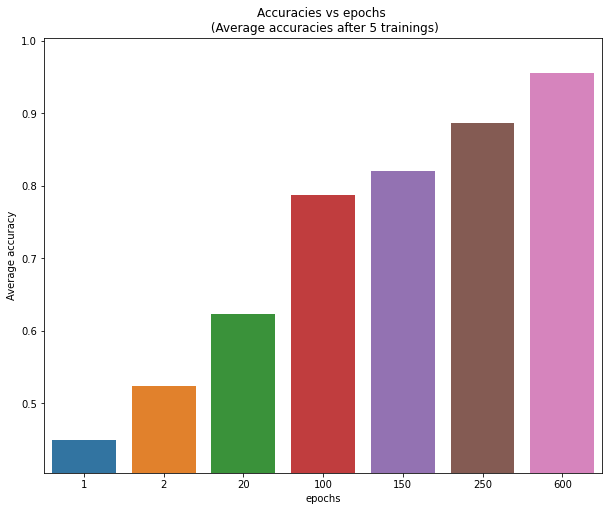

In [589]:
plt.figure(figsize=(10,8))
sns.barplot(x=epochs_values, y=avg_accuracies)
plt.title(f'Accuracies vs epochs \n (Average accuracies after {n_train_times} trainings)')
plt.ylabel('Average accuracy')
plt.xlabel('epochs')
plt.ylim(min(avg_accuracies)*.9)
pass;

Evolução da métrica acurácia em função do número de épocas



### 3)	 Modifique a taxa de aprendizado da Rede Neural. Escolha valores distintos (e.g. 0,001 e 0,1) e avalie os resultados.
OBS: Não use Early Stopping neste item.

#### Rascunho

#### Resposta

Estudo do loss em função da variação da taxa de aprendizagem (learning rate)

learning rate = 0.001


  0%|          | 0/4 [00:00<?, ?it/s]

learning rate = 0.005


  0%|          | 0/4 [00:00<?, ?it/s]

learning rate = 0.01


  0%|          | 0/4 [00:00<?, ?it/s]

learning rate = 0.025


  0%|          | 0/4 [00:00<?, ?it/s]

learning rate = 0.05


  0%|          | 0/4 [00:00<?, ?it/s]

learning rate = 0.1


  0%|          | 0/4 [00:00<?, ?it/s]

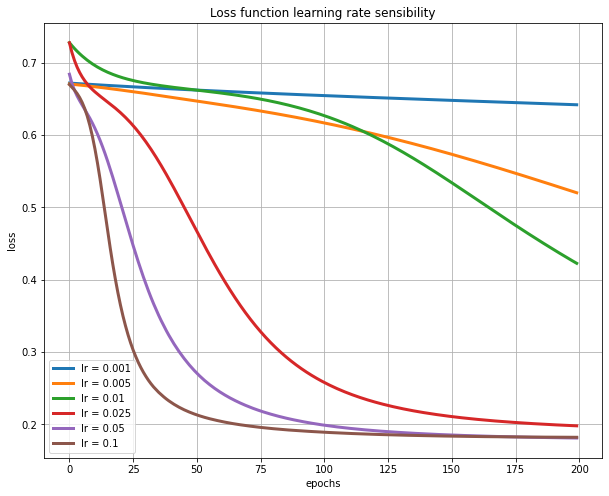

In [590]:
lr_values = [0.001, 0.005, 0.01, 0.025, 0.05, 0.1]
n_train_times = 4 # numero de treinamentos para cada valor de lr, reduzir efeito estocastico
avg_accuracies = [] # registrar a acuracia media para cada valor de epochs entre as repeticoes de treinamento
epochs = 200

plt.figure(figsize=(10,8))

for lr in lr_values:
  print (f'learning rate = {lr}')
  accuracies = []
  losses = []
  for _ in tqdm(range(n_train_times)):
    model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')
    history, _ = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary, skip=10000, progressBar=progressBar)
    y_pred = model.predict(test_dataset.X_data,binary=binary)
    cm = confusion_matrix(y_test, y_pred)
    accuracies.append( (cm[0,0]+cm[1,1])/cm.sum() )
    losses.append(history['loss_val'])
  accuracies = np.array(accuracies)
  avg_accuracies.append(accuracies.mean())

  # plotting best model (highest accuracy among trainings) loss
  index_best_model = np.argmax(accuracies)
  plt.plot(losses[index_best_model], label=f'lr = {lr}', linewidth=3)

plt.grid()
plt.title('Loss function learning rate sensibility')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
pass;

Nota-se no gráfico anterior que para um tempo de treinamento fixo (epochs) a rede treinada com uma taxa maior de aprendizagem (lr) aprende mais (redução de loss), o que implica numa melhor performance de classificação evidenciada pelo grafico a seguir (aumento de acurácia em função da taxa de aprendizagem - lr).

Com um tempo infinito de treinamento, é de se esperar que as redes convergiriam para performance semelhantes.

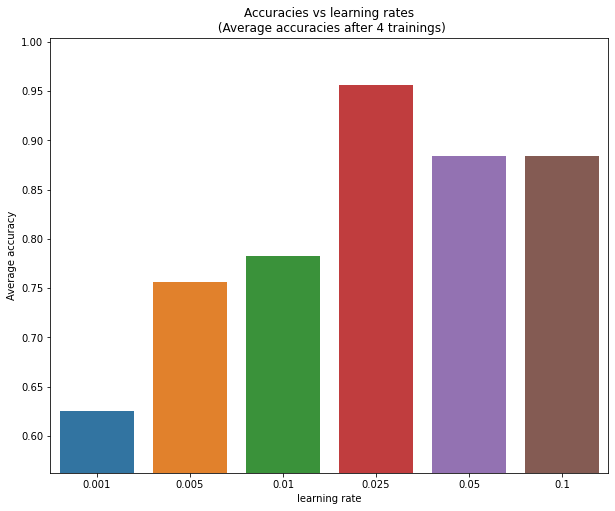

In [591]:
plt.figure(figsize=(10,8))
sns.barplot(x=lr_values, y=avg_accuracies)
plt.title(f'Accuracies vs learning rates\n (Average accuracies after {n_train_times} trainings)')
plt.ylabel('Average accuracy')
plt.xlabel('learning rate')
plt.ylim(min(avg_accuracies)*.9)
pass;

### 4)	Modifique a quantidade de neurônios na camada escondida da Rede Neural. Escolha valores distintos (e.g. 2 e 70 neurônios) e avalie os resultados.
OBS: Não use Early Stopping neste item.

#### Rascunho

#### Resposta

Estudo do loss em função da variação do número de neurônios na camada escondida.

hidden neurons = 2


  0%|          | 0/5 [00:00<?, ?it/s]

hidden neurons = 3


  0%|          | 0/5 [00:00<?, ?it/s]

hidden neurons = 5


  0%|          | 0/5 [00:00<?, ?it/s]

hidden neurons = 15


  0%|          | 0/5 [00:00<?, ?it/s]

hidden neurons = 30


  0%|          | 0/5 [00:00<?, ?it/s]

hidden neurons = 100


  0%|          | 0/5 [00:00<?, ?it/s]

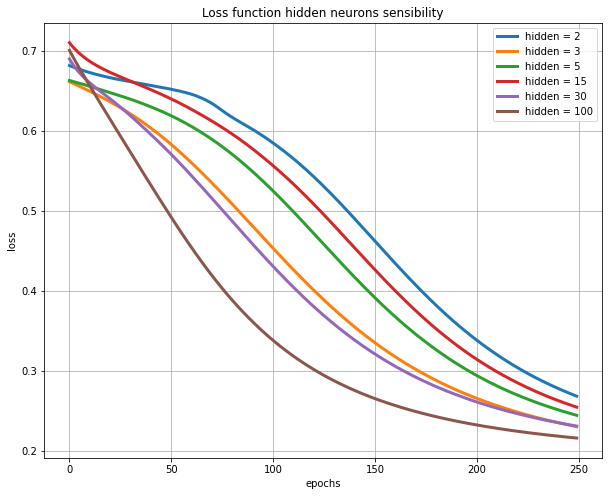

In [592]:
hn_values = [2,3,5,15,30,100]
n_train_times = 5 # numero de treinamentos para cada valor de hn, reduzir efeito estocastico
avg_accuracies = [] # registrar a acuracia media para cada valor de epochs entre as repeticoes de treinamento
epochs = 250
lr=0.01

plt.figure(figsize=(10,8))

for hn in hn_values:
  print (f'hidden neurons = {hn}')
  accuracies = []
  losses = []
  for _ in tqdm(range(n_train_times)):
    model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons=hn, output_activation='sigmoid')
    history, _ = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary, skip=10000, progressBar=progressBar)
    y_pred = model.predict(test_dataset.X_data,binary=binary)
    cm = confusion_matrix(y_test, y_pred)
    accuracies.append( (cm[0,0]+cm[1,1])/cm.sum() )
    losses.append(history['loss_val'])
  accuracies = np.array(accuracies)
  avg_accuracies.append(accuracies.mean())

  # plotting best model (highest accuracy among trainings) loss
  index_best_model = np.argmax(accuracies)
  plt.plot(losses[index_best_model], label=f'hidden = {hn}', linewidth=3)

plt.grid()
plt.title('Loss function hidden neurons sensibility')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
pass;

A partir do gráfico de loss acima e das acurácias abaixo, interpreatamos que a rede já consegue resolver o problema de classificação com poucos neurônios na camada escondida, para 7 entradas, que é o caso que selecionamos até aqui, não sendo necessária muita complexidade na camada escondida.

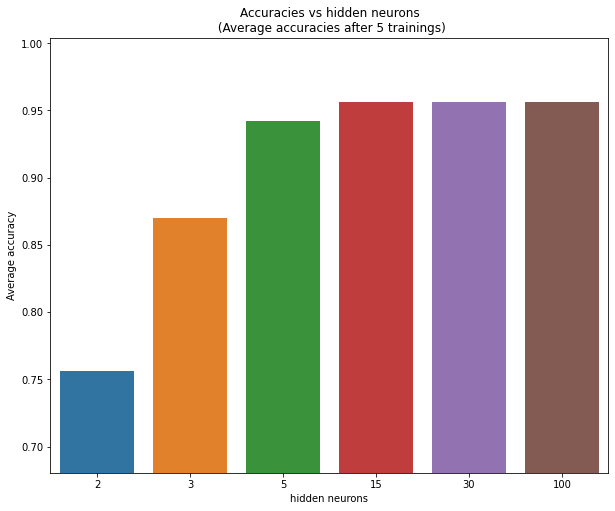

In [593]:
plt.figure(figsize=(10,8))
sns.barplot(x=hn_values, y=avg_accuracies)
plt.title(f'Accuracies vs hidden neurons\n (Average accuracies after {n_train_times} trainings)')
plt.ylabel('Average accuracy')
plt.xlabel('hidden neurons')
plt.ylim(min(avg_accuracies)*.9)
pass;

## Parte IV - Análise dos resultados

### 1)	Faça novos testes para avaliar o desempenho da Rede Neural no problema designado usando a técnica K-Fold (com K = 10). Comente o resultado obtido.

Dica: não é necessário utilizar a ferramenta KFold do scikit-learn para o desenvolvimento deste item. Uma alternativa <b> simples </b> é fazer um *for loop*, selecionando os índices em bloco. 

#### Rascunho

In [594]:
a=[1,2,3]
b=[4,5,6]

print ('List:')
print ('a:', a, 'b:', b)
print ('list a+b:', a+b)

print ('\nNumpy:')
a=np.array([1,2,3])
b=np.array([4,5,6])

print ('a:', a, 'b:', b)
print ('np a+b:',a+b)
c = np.concatenate((a,b))
print ('np concat:',c)

List:
a: [1, 2, 3] b: [4, 5, 6]
list a+b: [1, 2, 3, 4, 5, 6]

Numpy:
a: [1 2 3] b: [4 5 6]
np a+b: [5 7 9]
np concat: [1 2 3 4 5 6]


#### Resposta

Até aqui percebemos que os modelos treinados possuiram boa performance na classificação do dataset.

Sendo difícil evidenciar o ganho do k-fold quando os modelos treinados de forma convencional (com um possível viés de dataset) já possuem boa acurácia, vamos treinar um novo modelo como referência, em menos épocas do que os modelos anteriores. 

Em seguida reproduziremos as mesmas condições, porém aplicando a validação cruzada e compararemos com o modelo de referência.

In [595]:
test_size = 0.20
n_train_times = 2
epochs = 100
lr = 0.01

In [596]:
X = new_df.values[:,:-1].astype('float')

target = new_df.values[:,-1]
encoder = LabelEncoder()

y = encoder.fit_transform(target)
n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:  n_output = 1
else: n_output = encoder.classes_.shape[0]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=test_size,random_state=42)

if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

___
Modelo de referência (sem k-fold)
___

In [597]:
ref_accuracies = []
models = []
preds = []

# não sei porque tive que por essa linha fora do looping (estava dando o mesmo modelo sempre)
model = NeuralNetwork(n_input = n_input, n_output=n_output, output_activation='sigmoid')

for _ in tqdm(range(n_train_times)):
  model = NeuralNetwork(n_input = n_input, n_output=n_output, output_activation='sigmoid')
  history, _ = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary, skip=10000, progressBar=progressBar)  
  models.append(model)
  y_pred = model.predict(test_dataset.X_data,binary=binary)
  preds.append(y_pred)
  cm = confusion_matrix(y_test, y_pred)
  ref_accuracies.append( (cm[0,0]+cm[1,1])/cm.sum() )

# melhor modelo entre os n treinos
index_best = np.argmax(ref_accuracies)
ref_model = models[index_best]
y_pred_ref = preds[index_best]
ref_avg_accuracy = np.mean(ref_accuracies)

  0%|          | 0/2 [00:00<?, ?it/s]

In [598]:
print (ref_accuracies)
print (ref_avg_accuracy)

[0.8596491228070176, 0.7807017543859649]
0.8201754385964912


___
Modelo com k-fold
___

Separando teste

Separando conjunto fold = train + Val

In [599]:
X_fold, X_test, y_fold, y_test = train_test_split(X,y,test_size=test_size,random_state=42)
X_fold.shape[0], X_test.shape[0]

(455, 114)

Preparação do teste

In [600]:
if binary:
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

Separação do conjunto fold em train + validação

k configurações diferentes de treinamento e validação devem ser geradas aleatoriamente), ficando fixo, geralmente, apenas o conjunto de teste, que foi preparado anteriormente

In [601]:
folds = 10
validation_size = int(len(X_fold)/folds)
accs_folds = []
  
for k in tqdm(range(folds)):
  # print ('k=',k+1)
  # ******************* 1. dividir *********************
  # slicers
  l_slice = validation_size * k
  h_slice = l_slice + validation_size
  
  #separation between train and validation
  X_val = X_fold[l_slice:h_slice,:]
  X_train = np.concatenate ((X_fold[:l_slice,:], X_fold[h_slice+1:,:]))

  y_val = y_fold[l_slice:h_slice]
  y_train = np.concatenate ((y_fold[:l_slice], y_fold[h_slice+1:]))
  
  # print ('l=',l_slice,'h=',h_slice,'shape train=',X_train.shape,'shape val=',X_val.shape)

  # ******************* 2. condicionar *********************
  if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
  else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
  train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
  val_loader = DataLoader(dataset=val_dataset, batch_size=1)

  # ******************* 3. treinar n vezes dentro do fold *********************
  for _ in range(n_train_times):
    models = []
    accs_repetitions = []
    model = NeuralNetwork(n_input = n_input, n_output=n_output, output_activation='sigmoid')
    history, _ = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary, skip=10000, progressBar=False)
    models.append(model)

    # ******************* 3a. avaliar dentro do fold *********************
    y_pred = model.predict(val_dataset.X_data,binary=binary) # este predict é com val_dataset!!!
    cm = confusion_matrix(y_val, y_pred) # este y é com y_val!!!
    accs_repetitions.append( (cm[0,0]+cm[1,1])/cm.sum() )

  # melhor treino
  index_best_train_thisFold = np.argmax(accs_repetitions)
  best_acc_thisFold = accs_repetitions[index_best_train_thisFold]
  best_model_thisFold = models[index_best_train_thisFold]
  
  # ******************* 4. avaliar global e armazenar modelo *********************
  if k == 0:
    kfold_model = best_model_thisFold
    best_model_fold = 1
  else:
    if best_acc_thisFold > np.max(accs_folds):
      kfold_model = best_model_thisFold
      best_model_fold = k+1

  # ******************* 5. armazenar acuracia *********************
  accs_folds.append(best_acc_thisFold)


  0%|          | 0/10 [00:00<?, ?it/s]

In [602]:
print(f'Acurácia do modelo de referência(média): {ref_avg_accuracy:.2f}')
print()
print(f'Acurácia do melhor fold do k-fold: {np.max(accs_folds):.2f}')
print(f'Acurácia média do k-fold: {np.mean(accs_folds):.2f}')

Acurácia do modelo de referência(média): 0.82

Acurácia do melhor fold do k-fold: 0.91
Acurácia média do k-fold: 0.73


In [603]:
# predição no conjunto teste do modelo de referencia
cm_ref = confusion_matrix(y_test, y_pred_ref)

# predição do melhor modelo do k-fold deve ser refeita agora no conjunto de teste
y_pred_kfold = kfold_model.predict(test_dataset.X_data,binary=binary) # este predict agora é com o test_dataset!!!
cm_kfold = confusion_matrix(y_test, y_pred_kfold)

Reference


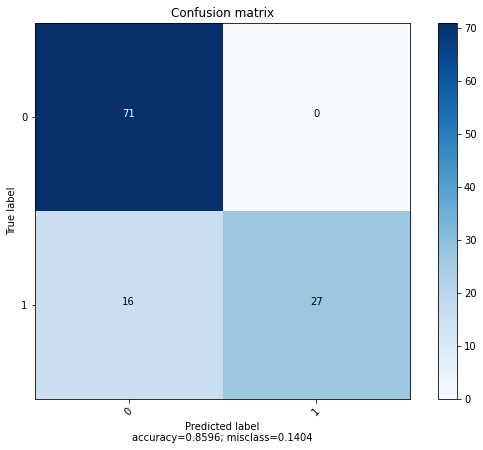


K-fold


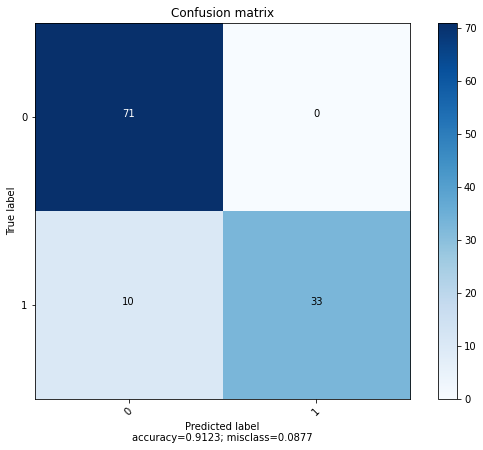

In [604]:
!echo 'Reference'
plot_confusion_matrix(cm_ref)

!echo;echo 'K-fold'
plot_confusion_matrix(cm_kfold)

Rodamos essa análise para várias configurações de parâmetros. Para modelos já de boa performance o k-fold não evidenciou ganho.

Já para casos de rede "menos treinada", há uma boa resposta da aplicação do k-fold em termos de produtividade.

Em resumo, entendo que o treinamento da rede está sendo mais importante do que algum viés de base de dados. Porém, o k-fold incrementa a performance da rede para acurácias mais baixas.



### 2)	Faça análises e novas implementações que você julgue importante para o seu trabalho. Não esqueça de explicar a motivação da análise realizada. 

colocar mais camadas
reducao de dimensionalidade?


#### Rascunho

In [605]:
# reducao de dimensionalidade comparar PCA com n vs n melhores features
# sensibilidade do tamanho do conjunto de teste
# avaliar influencia dos parametros do modelo (numero de entradas)

#### Resposta